Convert a MobileNet's weights to a C array.

TODO: Implement MobileNetv1-SSDLite with various optimizations and keep it fitting in an ESP32.

Imports.

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
from tensorflow.keras import layers
from tensorflow.keras import models

import os
import datetime
import warnings
import pathlib
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as keras_utils
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

%matplotlib inline

Modifiable variables.

In [2]:
training = True
trainable = True
fine_tuning = False
default_size = 128
alpha = 0.25
include_top = True
pooling = None
lr_patience = 10
stopper_patience = 3
batch_size = 32
num_classes = 6
epochs = 100
weights = None
split_weights = (8, 1, 1)
shuffle_buffer_size = 1024
fine_tune_at = -1
data_dir = '/media/samuel/DATA2/datasets/'

Try not to modify these variables.

In [3]:
input_shape = (default_size, default_size, 3)
x_size, y_size, channel_size = input_shape
origin = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
base_weight_path = ('https://github.com/JonathanCMitchell/mobilenet_v2_keras/releases/download/v1.1/')
model_filename = 'mobilenet_model_quantized'
model_tflite = model_filename + '.tflite'
model_cc = model_filename + '.cc'

Define MobileNetV2 model.

In [4]:
'''
def decode_predictions(preds, top_k=5, classes=['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']):
    if len(preds.shape) != 2:
        raise ValueError('`decode_predictions` expects a batch of predictions '
                         '(i.e. a 2D array of shape (samples, classes)). '
                         'Found array with shape: ' + str(preds.shape))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top_k:][::-1]
        result = [tuple(classes[i]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
        return results

def prepare_image(img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.imagenet_utils.preprocess_input(img_array_expanded_dims, mode='tf')

def resize_normalize(image, label, image_size=default_size):
    image = tf.cast(image,tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    return image / 255.0, label

def augment(image, label):  
    image = tf.image.random_flip_left_right(image)
    return tf.image.random_contrast(image, lower=0.0, upper=1.0), label

def MobileNet(input_shape=input_shape,
              alpha=alpha,
              depth_multiplier=depth_multiplier,
              dropout=dropout,
              include_top=include_top,
              weights=weights,
              input_tensor=input_tensor,
              pooling=pooling,
              classes=num_classes):
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either `None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` as true, `classes` should be 1000')

    if input_shape is None:
        default_size = default_size
    else:
        if K.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = default_size

    if K.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if depth_multiplier != 1:
            raise ValueError('If imagenet weights are being loaded, '
                             'depth multiplier must be 1')

        if alpha not in [0.25, 0.50, 0.75, 1.0]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of'
                             '`0.25`, `0.50`, `0.75` or `1.0` only.')

        if rows != cols or rows not in [128, 160, 192, 224]:
            rows = default_size
            warnings.warn('`input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. '
                          'Weights for input shape (224, 224) will be loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)

    if include_top:
        if K.image_data_format() == 'channels_first':
            shape = (int(1024 * alpha), 1, 1)
        else:
            shape = (1, 1, int(1024 * alpha))

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Reshape(shape, name='reshape_1')(x)
        x = layers.Dropout(dropout, name='dropout')(x)
        x = layers.Conv2D(classes, (1, 1), padding='same', name='conv_preds')(x)
        x = layers.Reshape((classes,), name='reshape_2')(x)
        x = layers.Activation('softmax', name='act_softmax')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = models.Model(inputs, x, name='mobilenet_%0.2f_%s' % (alpha, rows))

    if weights == 'imagenet':
        if alpha == 1.0:
            alpha_text = '1_0'
        elif alpha == 0.75:
            alpha_text = '7_5'
        elif alpha == 0.50:
            alpha_text = '5_0'
        else:
            alpha_text = '2_5'

        if include_top:
            model_name = 'mobilenet_%s_%d_tf.h5' % (alpha_text, rows)
            weight_path = base_weight_path + model_name
            weights_path = keras_utils.get_file(model_name,
                                                weight_path,
                                                cache_subdir='models')
        else:
            model_name = 'mobilenet_%s_%d_tf_no_top.h5' % (alpha_text, rows)
            weight_path = base_weight_path + model_name
            weights_path = keras_utils.get_file(model_name,
                                                weight_path,
                                                cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model

def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    filters = int(filters * alpha)
    x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(inputs)
    x = layers.Conv2D(filters, kernel,
                      padding='valid',
                      use_bias=False,
                      strides=strides,
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return layers.ReLU(6., name='conv1_relu')(x)

def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha, depth_multiplier=1, strides=(1, 1), block_id=1):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = layers.ZeroPadding2D(((0, 1), (0, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = layers.DepthwiseConv2D((3, 3),
                               padding='same' if strides == (1, 1) else 'valid',
                               depth_multiplier=depth_multiplier,
                               strides=strides,
                               use_bias=False,
                               name='conv_dw_%d' % block_id)(x)
    x = layers.BatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)

    x = layers.Conv2D(pointwise_conv_filters, (1, 1),
                      padding='same',
                      use_bias=False,
                      strides=(1, 1),
                      name='conv_pw_%d' % block_id)(x)
    x = layers.BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)
    return layers.ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

@tf.function
def weighted_f1_score(y_true, y_pred, sample_weight=None):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_true = tf.math.rint(y_true)
    y_pred = tf.math.rint(y_pred)
    y_true = tf.dtypes.cast(y_true, tf.int32)
    y_pred = tf.dtypes.cast(y_pred, tf.int32)
    y_true = tf.one_hot(y_true, depth=2)
    y_pred = tf.one_hot(y_pred, depth=2)
    scorer = tfa.metrics.F1Score(num_classes=num_classes, average='weighted')
    scorer.update_state(y_true, y_pred)
    return scorer.result()
'''

'\ndef decode_predictions(preds, top_k=5, classes=[\'dandelion\', \'daisy\', \'tulips\', \'sunflowers\', \'roses\']):\n    if len(preds.shape) != 2:\n        raise ValueError(\'`decode_predictions` expects a batch of predictions \'\n                         \'(i.e. a 2D array of shape (samples, classes)). \'\n                         \'Found array with shape: \' + str(preds.shape))\n    results = []\n    for pred in preds:\n        top_indices = pred.argsort()[-top_k:][::-1]\n        result = [tuple(classes[i]) + (pred[i],) for i in top_indices]\n        result.sort(key=lambda x: x[2], reverse=True)\n        results.append(result)\n        return results\n\ndef prepare_image(img):\n    img_array = tf.keras.preprocessing.image.img_to_array(img)\n    img_array_expanded_dims = np.expand_dims(img_array, axis=0)\n    return tf.keras.applications.imagenet_utils.preprocess_input(img_array_expanded_dims, mode=\'tf\')\n\ndef resize_normalize(image, label, image_size=default_size):\n    image = 

In [5]:
def decode_predictions(preds, top_k=5, classes=['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']):
    if len(preds.shape) != 2:
        raise ValueError('`decode_predictions` expects a batch of predictions '
                         '(i.e. a 2D array of shape (samples, classes)). '
                         'Found array with shape: ' + str(preds.shape))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top_k:][::-1]
        result = [tuple(classes[i]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
        return results

def prepare_image(img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.imagenet_utils.preprocess_input(img_array_expanded_dims, mode='tf')

def resize_normalize(image, label, image_size=default_size):
    image = tf.cast(image,tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    return image / 255.0, label

def augment(image, label):  
    image = tf.image.random_flip_left_right(image)
    return tf.image.random_contrast(image, lower=0.0, upper=1.0), label

def correct_pad(inputs, kernel_size):
    img_dim = 2 if K.image_data_format() == 'channels_first' else 1
    input_size = K.int_shape(inputs)[img_dim:(img_dim + 2)]

    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)

    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)

    correct = (kernel_size[0] // 2, kernel_size[1] // 2)

    return ((correct[0] - adjust[0], correct[0]), (correct[1] - adjust[1], correct[1]))

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000):
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either `None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` as true, `classes` should be 1000')

    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = K.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = K.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if K.image_data_format == 'channels_first':
                if K.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if K.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor, 'is not a keras tensor')

    if input_shape is None and input_tensor is not None:
        try:
            K.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and K.is_keras_tensor(input_tensor):
            if K.image_data_format() == 'channels_first':
                rows = K.int_shape(input_tensor)[2]
                cols = K.int_shape(input_tensor)[3]
            else:
                rows = K.int_shape(input_tensor)[1]
                cols = K.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows

    else:
        if K.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows

    if K.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, `1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = default_size
            warnings.warn('`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.ZeroPadding2D(padding=correct_pad(img_input, 3), name='Conv1_pad')(img_input)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=10)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=11)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=12)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2, expansion=6, block_id=13)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=14)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=15)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters, kernel_size=1, use_bias=False, name='Conv_1')(x)
    x = layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999, name='Conv_1_bn')(x)
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = models.Model(inputs, x, name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' +
                          str(alpha) + '_' + str(rows) + '.h5')
            weight_path = base_weight_path + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' +
                          str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = base_weight_path + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    in_channels = K.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)

    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(x, 3), name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3,
                               strides=stride,
                               activation=None,
                               use_bias=False,
                               padding='same' if stride == 1 else 'valid',
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'depthwise_BN')(x)

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    x = layers.Conv2D(pointwise_filters,
                      kernel_size=1,
                      padding='same',
                      use_bias=False,
                      activation=None,
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

@tf.function
def weighted_f1_score(y_true, y_pred, sample_weight=None):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_true = tf.math.rint(y_true)
    y_pred = tf.math.rint(y_pred)
    y_true = tf.dtypes.cast(y_true, tf.int32)
    y_pred = tf.dtypes.cast(y_pred, tf.int32)
    y_true = tf.one_hot(y_true, depth=2)
    y_pred = tf.one_hot(y_pred, depth=2)
    scorer = tfa.metrics.F1Score(num_classes=num_classes, average='weighted')
    scorer.update_state(y_true, y_pred)
    return scorer.result()

Instanciate model.

In [6]:
model = MobileNetV2(input_shape=input_shape, 
                    alpha=alpha, 
                    include_top=include_top, 
                    weights=weights, 
                    pooling=pooling, 
                    classes=num_classes)

Configure training.

In [7]:
# Optimization strategy.
#optimizer = tf.keras.optimizers.Nadam()
#optimizer = tfa.optimizers.RectifiedAdam()
optimizer = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
#optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=6, slow_step_size=0.5)

# Backpropagated loss function.
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Training configuration.
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=['accuracy', 
                       'mean_squared_error', 
                       'mean_absolute_error', 
                       'mean_squared_logarithmic_error', 
                       'categorical_crossentropy'])

# Save model weights after each epoch if validation loss decreased.
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', 
                                                  monitor='val_categorical_crossentropy', 
                                                  mode='min', 
                                                  verbose=1, 
                                                  save_best_only=True, 
                                                  save_weights_only=False, 
                                                  save_freq='epoch')

# Reduce learning rate when there is less change in monitored value.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 mode='max',
                                                 min_delta=0.01,
                                                 patience=lr_patience,
                                                 factor=0.25,
                                                 verbose=1,
                                                 cooldown=0,
                                                 min_lr=0.00000001)

# Automagic epoch setup.
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy', 
                                           mode='min', 
                                           patience=stopper_patience, 
                                           restore_best_weights=True, 
                                           verbose=1)

# Print model.
model.summary()

Model: "mobilenetv2_0.25_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 8)    216         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 8)    32          Conv1[0][0]                      
_______________________________________________________________________________

Plot the model.

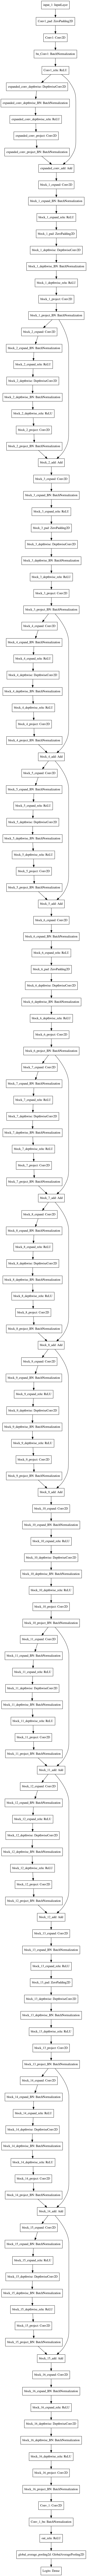

In [8]:
tf.keras.utils.plot_model(model, to_file='model.png')

Download dataset.

Number of training samples 2936
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


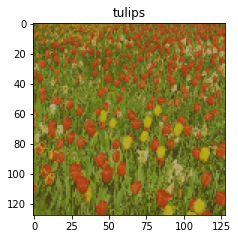

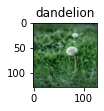

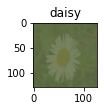

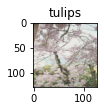

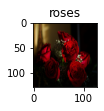

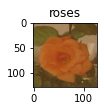

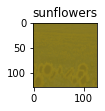

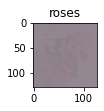

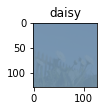

In [9]:
split = list(tfds.Split.TRAIN.subsplit(weighted=split_weights))
(raw_train, raw_val, raw_test), metadata = tfds.load(name='tf_flowers', 
                                                     split=split, 
                                                     data_dir=data_dir, 
                                                     as_supervised=True, 
                                                     with_info=True)

num_train, num_val, num_test = (metadata.splits['train'].num_examples * weight / 10 for weight in split_weights)

print('Number of training samples %d' % num_train)
 
train = raw_train.map(resize_normalize)
val = raw_val.map(resize_normalize)
test = raw_test.map(resize_normalize)

train = train.map(augment)

train = train.shuffle(shuffle_buffer_size).batch(batch_size)
val = val.batch(batch_size)
test = test.batch(batch_size)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

labels = metadata.features['label']
get_label_name = labels.int2str
classes = list(map(get_label_name, range(labels.num_classes)))
print(classes)

plt.figure(figsize=(12, 12)) 
for btch in train.take(1):
    for i in range(9):
        img, lbl = btch[0][i], btch[1][i]
        plt.subplot(3, 3, i + 1)
        plt.title(get_label_name(lbl.numpy()))
        plt.imshow(img)
        plt.show()

steps_per_epoch = round(num_train) // batch_size
validation_steps = round(num_val) // batch_size

log_dir='runs/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
os.makedirs(log_dir)

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir, 
    target_size=(default_size, default_size), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=batch_size, 
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir, 
    target_size=(default_size, default_size), 
    color_mode='rgb', 
    class_mode='categorical', 
    batch_size=batch_size, 
    subset='validation'
)

Found 235869 images belonging to 6 classes.
Found 58967 images belonging to 6 classes.


Use Keras' image generator.

Train model.

In [11]:
if training:
    if fine_tuning:
        model.trainable = False
        for layer in model.layers[:fine_tune_at]:
            layer.trainable = True

    history = model.fit(x=train_generator, 
                        validation_data=validation_generator, 
                        steps_per_epoch=steps_per_epoch, 
                        validation_steps=validation_steps, 
                        epochs=epochs, 
                        verbose=1, 
                        callbacks=[checkpointer, reduce_lr, stopper], 
                        shuffle=True).history

Epoch 1/100
91/91 [==============================] - ETA: 0s - loss: 1.1486 - accuracy: 0.9313 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0400 - mean_squared_logarithmic_error: 0.0076 - categorical_crossentropy: 0.2142
Epoch 00001: val_categorical_crossentropy improved from inf to 1.66363, saving model to model.h5
91/91 [==============================] - 38s 414ms/step - loss: 1.1486 - accuracy: 0.9313 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0400 - mean_squared_logarithmic_error: 0.0076 - categorical_crossentropy: 0.2142 - val_loss: 1.7690 - val_accuracy: 1.0000 - val_mean_squared_error: 0.1314 - val_mean_absolute_error: 0.2702 - val_mean_squared_logarithmic_error: 0.0638 - val_categorical_crossentropy: 1.6636 - lr: 0.0010
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 1.0454 - accuracy: 1.0000 - mean_squared_error: 1.8443e-06 - mean_absolute_error: 7.6117e-04 - mean_squared_logarithmic_error: 6.9919e-07 - categorical_crossentropy: 0.0023



Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
91/91 [==============================] - 36s 400ms/step - loss: 1.0440 - accuracy: 1.0000 - mean_squared_error: 1.1038e-07 - mean_absolute_error: 1.8493e-04 - mean_squared_logarithmic_error: 4.1791e-08 - categorical_crossentropy: 5.5507e-04 - val_loss: 1.4762 - val_accuracy: 1.0000 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1687 - val_mean_squared_logarithmic_error: 0.0220 - val_categorical_crossentropy: 0.7054 - lr: 0.0010
Epoch 12/100
91/91 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 1.0000 - mean_squared_error: 9.5380e-08 - mean_absolute_error: 1.7124e-04 - mean_squared_logarithmic_error: 3.6127e-08 - categorical_crossentropy: 5.1396e-04
Epoch 00012: val_categorical_crossentropy improved from 0.70541 to 0.62951, saving model to model.h5
91/91 [==============================] - 36s 397ms/step - loss: 1.0440 - accuracy: 1.0000 - mean_squared_error: 9.5380e-08 -

Epoch 22/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.4368e-08 - mean_absolute_error: 1.4182e-04 - mean_squared_logarithmic_error: 2.4374e-08 - categorical_crossentropy: 4.2563e-04
Epoch 00022: val_categorical_crossentropy improved from 0.20307 to 0.17978, saving model to model.h5
91/91 [==============================] - 36s 395ms/step - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.4368e-08 - mean_absolute_error: 1.4182e-04 - mean_squared_logarithmic_error: 2.4374e-08 - categorical_crossentropy: 4.2563e-04 - val_loss: 1.1759 - val_accuracy: 1.0000 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0548 - val_mean_squared_logarithmic_error: 0.0021 - val_categorical_crossentropy: 0.1798 - lr: 6.2500e-05
Epoch 23/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.8235e-08 - mean_absolute_error: 1.4533e-04 - mean_squared_logarithmic_error: 2.58

91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3098e-08 - mean_absolute_error: 1.3912e-04 - mean_squared_logarithmic_error: 2.3900e-08 - categorical_crossentropy: 4.1750e-04
Epoch 00032: val_categorical_crossentropy improved from 0.07205 to 0.06668, saving model to model.h5
91/91 [==============================] - 36s 400ms/step - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3098e-08 - mean_absolute_error: 1.3912e-04 - mean_squared_logarithmic_error: 2.3900e-08 - categorical_crossentropy: 4.1750e-04 - val_loss: 1.0944 - val_accuracy: 1.0000 - val_mean_squared_error: 8.4433e-04 - val_mean_absolute_error: 0.0215 - val_mean_squared_logarithmic_error: 3.2770e-04 - val_categorical_crossentropy: 0.0667 - lr: 1.5625e-05
Epoch 33/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.1223e-08 - mean_absolute_error: 1.3790e-04 - mean_squared_logarithmic_error: 2.3178e-0

91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.2017e-08 - mean_absolute_error: 1.3841e-04 - mean_squared_logarithmic_error: 2.3478e-08 - categorical_crossentropy: 4.1538e-04
Epoch 00042: val_categorical_crossentropy improved from 0.03941 to 0.03754, saving model to model.h5
91/91 [==============================] - 36s 401ms/step - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.2017e-08 - mean_absolute_error: 1.3841e-04 - mean_squared_logarithmic_error: 2.3478e-08 - categorical_crossentropy: 4.1538e-04 - val_loss: 1.0725 - val_accuracy: 1.0000 - val_mean_squared_error: 2.7536e-04 - val_mean_absolute_error: 0.0123 - val_mean_squared_logarithmic_error: 1.0635e-04 - val_categorical_crossentropy: 0.0375 - lr: 3.9063e-06
Epoch 43/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.0027e-08 - mean_absolute_error: 1.3631e-04 - mean_squared_logarithmic_error: 2.2723e-0

91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3249e-08 - mean_absolute_error: 1.3758e-04 - mean_squared_logarithmic_error: 2.3946e-08 - categorical_crossentropy: 4.1290e-04
Epoch 00052: val_categorical_crossentropy improved from 0.02492 to 0.02371, saving model to model.h5
91/91 [==============================] - 36s 393ms/step - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3249e-08 - mean_absolute_error: 1.3758e-04 - mean_squared_logarithmic_error: 2.3946e-08 - categorical_crossentropy: 4.1290e-04 - val_loss: 1.0619 - val_accuracy: 1.0000 - val_mean_squared_error: 1.1123e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_logarithmic_error: 4.2722e-05 - val_categorical_crossentropy: 0.0237 - lr: 9.7656e-07
Epoch 53/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 5.9371e-08 - mean_absolute_error: 1.3665e-04 - mean_squared_logarithmic_error: 2.2468e-0

91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.2539e-08 - mean_absolute_error: 1.3740e-04 - mean_squared_logarithmic_error: 2.3672e-08 - categorical_crossentropy: 4.1236e-04
Epoch 00062: val_categorical_crossentropy improved from 0.01431 to 0.01339, saving model to model.h5
91/91 [==============================] - 36s 393ms/step - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.2539e-08 - mean_absolute_error: 1.3740e-04 - mean_squared_logarithmic_error: 2.3672e-08 - categorical_crossentropy: 4.1236e-04 - val_loss: 1.0540 - val_accuracy: 1.0000 - val_mean_squared_error: 3.6155e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_logarithmic_error: 1.3847e-05 - val_categorical_crossentropy: 0.0134 - lr: 2.4414e-07
Epoch 63/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.4078e-08 - mean_absolute_error: 1.3964e-04 - mean_squared_logarithmic_error: 2.4254e-0

91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.1263e-08 - mean_absolute_error: 1.3789e-04 - mean_squared_logarithmic_error: 2.3187e-08 - categorical_crossentropy: 4.1382e-04
Epoch 00072: val_categorical_crossentropy improved from 0.00725 to 0.00695, saving model to model.h5
91/91 [==============================] - 36s 393ms/step - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.1263e-08 - mean_absolute_error: 1.3789e-04 - mean_squared_logarithmic_error: 2.3187e-08 - categorical_crossentropy: 4.1382e-04 - val_loss: 1.0490 - val_accuracy: 1.0000 - val_mean_squared_error: 1.0130e-05 - val_mean_absolute_error: 0.0023 - val_mean_squared_logarithmic_error: 3.8723e-06 - val_categorical_crossentropy: 0.0069 - lr: 6.1035e-08
Epoch 73/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3701e-08 - mean_absolute_error: 1.3912e-04 - mean_squared_logarithmic_error: 2.4113e-0

91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3241e-08 - mean_absolute_error: 1.3827e-04 - mean_squared_logarithmic_error: 2.3939e-08 - categorical_crossentropy: 4.1498e-04
Epoch 00082: val_categorical_crossentropy improved from 0.00292 to 0.00261, saving model to model.h5
91/91 [==============================] - 36s 393ms/step - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3241e-08 - mean_absolute_error: 1.3827e-04 - mean_squared_logarithmic_error: 2.3939e-08 - categorical_crossentropy: 4.1498e-04 - val_loss: 1.0456 - val_accuracy: 1.0000 - val_mean_squared_error: 1.5849e-06 - val_mean_absolute_error: 8.6958e-04 - val_mean_squared_logarithmic_error: 6.0237e-07 - val_categorical_crossentropy: 0.0026 - lr: 1.5259e-08
Epoch 83/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.2200e-08 - mean_absolute_error: 1.3857e-04 - mean_squared_logarithmic_error: 2.354

91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3378e-08 - mean_absolute_error: 1.3814e-04 - mean_squared_logarithmic_error: 2.3993e-08 - categorical_crossentropy: 4.1458e-04
Epoch 00092: val_categorical_crossentropy improved from 0.00123 to 0.00112, saving model to model.h5
91/91 [==============================] - 37s 403ms/step - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.3378e-08 - mean_absolute_error: 1.3814e-04 - mean_squared_logarithmic_error: 2.3993e-08 - categorical_crossentropy: 4.1458e-04 - val_loss: 1.0445 - val_accuracy: 1.0000 - val_mean_squared_error: 3.4381e-07 - val_mean_absolute_error: 3.7381e-04 - val_mean_squared_logarithmic_error: 1.3018e-07 - val_categorical_crossentropy: 0.0011 - lr: 1.0000e-08
Epoch 93/100
91/91 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 1.0000 - mean_squared_error: 6.1190e-08 - mean_absolute_error: 1.3766e-04 - mean_squared_logarithmic_error: 2.315

Retrieve and show image before inference.

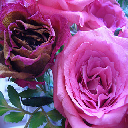

In [12]:
data_dir = pathlib.Path(tf.keras.utils.get_file(origin=origin, fname='flower_photos', untar=True))
flower_path = list(data_dir.glob('*roses*/*'))[0]
img = tf.keras.preprocessing.image.load_img(flower_path, target_size=input_shape)
img

Inference and display of decoded results.

In [16]:
preprocessed_image = prepare_image(img)
predictions = model.predict(preprocessed_image)
decode_predictions(predictions, top_k=5, classes=[(0, 'dandelion'), 
                                                  (1, 'daisy'), 
                                                  (2, 'tulips'), 
                                                  (3, 'sunflowers'), 
                                                  (4, 'roses'), 
                                                  (5, 'unknown')])

[[(2, 'daisy', 0.99721056),
  (3, 'tulips', 0.00087361055),
  (5, 'roses', 0.00053392304),
  (1, 'dandelion', 0.00049440743),
  (4, 'sunflowers', 0.000456977)]]

Optimize for size (quantize weights) then convert to bytecode.

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
open(model_tflite, 'wb').write(converter.convert())

ConverterError: See console for info.
2020-10-19 13:09:21.633152: W tensorflow/compiler/mlir/lite/python/graphdef_to_tfl_flatbuffer.cc:144] Ignored output_format.
2020-10-19 13:09:21.633172: W tensorflow/compiler/mlir/lite/python/graphdef_to_tfl_flatbuffer.cc:147] Ignored drop_control_dependency.
2020-10-19 13:09:21.661583: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-10-19 13:09:21.684102: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2699905000 Hz
2020-10-19 13:09:21.684741: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f830b9ee80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-19 13:09:21.684779: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-10-19 13:09:21.686204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-10-19 13:09:21.690898: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-19 13:09:21.691216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro M3000M computeCapability: 5.2
coreClock: 0.924GHz coreCount: 8 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 149.31GiB/s
2020-10-19 13:09:21.691588: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-10-19 13:09:21.694754: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-10-19 13:09:21.696537: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-10-19 13:09:21.698255: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-10-19 13:09:21.701961: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-10-19 13:09:21.703226: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-10-19 13:09:21.715799: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-10-19 13:09:21.716087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-19 13:09:21.716859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-19 13:09:21.717403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1703] Adding visible gpu devices: 0
2020-10-19 13:09:21.717507: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-10-19 13:09:21.800721: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-10-19 13:09:21.800740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1108]      0 
2020-10-19 13:09:21.800758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1121] 0:   N 
2020-10-19 13:09:21.800913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-19 13:09:21.801219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-19 13:09:21.801508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-19 13:09:21.801746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1247] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 60 MB memory) -> physical GPU (device: 0, name: Quadro M3000M, pci bus id: 0000:01:00.0, compute capability: 5.2)
2020-10-19 13:09:21.803377: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f8315b2f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-10-19 13:09:21.803390: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro M3000M, Compute Capability 5.2
2020-10-19 13:09:21.811535: I tensorflow/stream_executor/cuda/cuda_driver.cc:763] failed to allocate 60.38M (63307776 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2020-10-19 13:09:21.830497: F ./tensorflow/core/kernels/conv_2d_gpu.h:659] Non-OK-status: GpuLaunchKernel( SwapDimension1And2InTensor3UsingTiles<T, NumThreads, TileLongSide, TileShortSide>, total_tiles_count, NumThreads, 0, d.stream(), input, input_dims, output) status: Internal: out of memory
Fatal Python error: Aborted

Current thread 0x00007f1be8d40740 (most recent call first):
  File "/opt/conda/envs/school/lib/python3.8/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 50 in execute
  File "/opt/conda/envs/school/lib/python3.8/site-packages/absl/app.py", line 251 in _run_main
  File "/opt/conda/envs/school/lib/python3.8/site-packages/absl/app.py", line 300 in run
  File "/opt/conda/envs/school/lib/python3.8/site-packages/tensorflow/python/platform/app.py", line 40 in run
  File "/opt/conda/envs/school/lib/python3.8/site-packages/tensorflow/lite/toco/python/toco_from_protos.py", line 93 in main
  File "/opt/conda/envs/school/bin/toco_from_protos", line 11 in <module>
Aborted (core dumped)




Convert the bytecode to characters representing C arrays (the weights).

In [ ]:
!xxd -i $model_tflite > $model_cc
!cat $model_cc